In [43]:
# pending to add to the dockerfile
!pip install imbalanced-learn
!pip install mlxtend  
#import imblearn

#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim
#from torch.utils.data import Dataset, DataLoader

from mlxtend.evaluate import bias_variance_decomp
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import SMOTE
from numpy import where
from sklearn.preprocessing import StandardScaler, MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, precision_score
    

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


## Target - Growth - Predictive model based on previous growth partterns - Classifier.

The goal is to be able to predict if an account would growth over a certain $ amount or not based on previous years features


### Results so far:

https://docs.google.com/spreadsheets/d/19TkOloNYnj5wjaQExMarblklVuqSHlB0DWz2noZpl74/edit#gid=1839961543

**2020-11-26 NF:**

- Set two different target functions, over 25% and over 10% growth
- Refactored code to run separate models for Large / Mid-Market per target function
- Ran hyperparamethers optimisation, but got just minor improvements
- Ran cross-validation at 100 folds to estimate confidence intervals, although haven't been able to obtain the results for the positive class
- Ran Recursive Feature Elimination, but ended up staying with all features for the time being
- Results are imported in an gSheet file for analysis

As a strategy for implementation, we should decide a threshold probability where we would want to set the flag as "predicted" for 25% and 10%.

The higher the prob, the higher our recall / precision, but the fewer accounts we capture. That's the balance.


**2020-11-20 NF:**

- Set goal to 25% growth for Large, as Median is around 13% it seems a reasonable number. 
  - Average growth is 150%, but this figure is highly skewed, and model precision goes down as we increase the growth target
- Added new features from the Delta ARR table, seems to drive positive impact
- I'm running out of ideas for easy to add features, any thoughts? The more features the better!
- Next step is to refactor the code to allow to run multiple runs against test data, and a final validation with validation data.
- Also optimizing number of features (remove not needed)
- Also optimizing hyper parameters would be beneficial
- Also testing different balancing strategies

In general, if I am reading this correctly, we are getting around 70% precision on the subset of "predicted to grow 25%" accounts. This is without testing against validation dataset, so it probably overfiting. In any case, I think we are making progress.

Adding more features should still be the focus.

**2020-11-17 - NF:**

- Added option to change between % and $
- Added ping count of hosts and average users per period
- Added bizible touchpoints data
- Added task counts

**2020-11-12 - NF:**

- Large Segment for over 10k growth, provides a reasonable recall of 0.65. It would flag around 5% of accounts with a 65% probability of growth.
- Mid-Market is not working well... Need to retest and rethink balancing of data

### Questions for Tye:

- How to deal with categories that show in training data set but not in prediction
- What would be your suggestion to deal with umbalanced datasets
- - Use weights on the models for the classes 
- RandomForest vs LogRegression?
- - RandomForest is non-linear,scaling is not necesary unless we want to run interpretation
- Ideas to deal with extreme values?
    Random Forest has no issue dealing with extreme values
    
### Features used:

- ARR for last and previous periods by year (removed growth as it is related to this one)
- Created opties for -1 period (between -1 year of period date and -2 year) and previous periods.
    - Created opties are related to ARR in current period. Avoid bringing future information into the model
- Won deals for -1 / -2 periods
- Lost deals for -1 / -2 periods
- Created contacts for - 1 / -2 /-3 periods
- Created Zendesk tickets for - 1 / - 2 / -3
- Tasks set up in SFDC for - 1 / - 2 / -3
- Bizible Touchpoints for - 1 / - 2 / -3
- From Ping data Count of Pings / Avg Users per Instance.
- Change ARR by Tier, Seats Price per Periods
- Products per Period
- Industry
- Number of Seats

### Issues:
- Growth rate has no meaning when previous period is 0
    - To deal with this, I set growth to 100% the first time an account captures value
- When moved into $ amount as growth flag trigger, data became pretty unbalanced
    - Trying to standardize it using the OneSidedSelection method. [Article followed](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/) 
- Dealing with outliers
    - For random forest I read that standardizing inputs is not needed, I have some commented methods from the attemp at NN
- Recall / Precision still pretty low
    - We can try adding marketing / support / events metrics or different models
- Exclude main accounts
    - Within the extract query I removed the top 15 accounts per segment, also the model should be run by segment
- The model doesn't consider prospects, as it requires previous ARR as main predictive attribute

### Next steps:


- Hyper Parameters optimization
- Encapsulate process in functions and run n-1 loops to identify best parameters combination (bootstrap)
  - This is needed because we do have very little data
- Test different data balancing methodologies


- ~~Adapt Melia's code to my format, include the variables~~
- ~~Adjust prediction to use growth variables too~~
- ~~Run model with Melias approach~~ 
- ~~Add Product classification~~ 
- ~~Growth analysis~~
- ~~Divide dataset in 3 pieces. Train 80%, Test-Train 10%, Validate 10%.~~
- ~~Filter out accounts with no ARR in any of the last two periods, test results~~
- Add new features:
    - Lead creation by period - Try match account field
    - MQLs created by period 
    - ~~Task~~ and Events by period
    - Has bitbucket flag?
    - ~~PRIORITY-Industry Flag~~
    - ~~PRIORITY-Churn Amount per period (related to ARR)~~
    - True Up per Period (related to ARR)
    - ~~Tier upgrades, seat amount changes, ARR expansion, ARR contraction within the period~~
    - ~~Ping usage when available per account per period~~
    - Any other?
 
## Other questions to tackle:

- Is this account going to churn?

## Data sources:

- Training data [Sisense Extract](https://app.periscopedata.com/app/gitlab/700340/WIP-:-NF-Multiple-Request?widget=10160436&udv=0)
- Prediction data [Sisense Extract](https://app.periscopedata.com/app/gitlab/700340/WIP-:-NF-Multiple-Request?widget=10212347&udv=0)

### 

- Add excluded accounts back into the model 
- If needed move model to Account level from Parent and test performance
- Compare both models PTB vs ML
- Medium Term: Move timeframe to quarter

- Talk to Kat, try to validate the code is doing what it should be doing
- Try again flag with last three periods had ARR only

- Add new easy data - e.g. LAM / TAM / # of developers



### Jake Guidance 2020-12-01

- Test the model adding back the excluded accounts
- Test probability of not growing 

### Tye Guidance 2020-11-17

- 80% to train, 10% to validate, 10% for final metric
- Check parameters on the forest model capping, leafs, optimizations of parameters for random forest are critical
- Very few records, need to balance through resampling, but recommended is bootstrapping
- Do n - 1 loops on the training part, once the model is set up go to test the last 10%
- Outerloop remove variable, train a hundred times, resample from the training dataset (bootstrap), compare confidence intervals across each run, check for distribution differences across the runs
- When assesing the "prediction" probability, look at the predicted prob distributions, as they might not be calibrated, ignore the middle, focus on the edges.

### Melia 2020-11-17

- Created a dataset to be integrated [dataset](https://app.periscopedata.com/app/gitlab/529915/WIP:-Melia-Vilain?widget=10303022&udv=0)
- Move away from all data and test considering only accounts with ARR in both of the last two periods
- Calculate the median growth for the group, set that as the target for decision making 

### Jake Guidance 2020-11-10

- Move back to growth for target
- Think of adding ARR changes by period, e.g. Expansion, Contraction, Tier upgrade
- How can we asses the amount we will growth? Knowing that is going to grow over a certain amount might not be enough.

### Tye Guidance 2020-11-05

- Check balance of metrics, unbalance is bad for random forest
- Talk to folks identify the key data points, diminishing returns in trying to pursue every feature
- Check probability of predictions, select just top precision items only .85 / .9
- IMPORTANT: Be careful with the accounts we include, avoid bleeding data from the future into the current data set
- IMPORTANT: Maybe we need to exclude big accounts, as they get a lot of attention, different approach, same applies to small accounts
- IMPORTANT: Separate models for segments, try to use data when posisble but it is a mix
- Add flag for reasons of e.g. growth, grew by seats -1, great by seats -2
- Iterate through the features, try to check them individually if possible, and trim them into a set of those
- Build dashboards to gut check results of models
- Start with logistic regression and then move to random forest
- Logistic regression is very clean to interpret
- Try to stay with classification vs predicting amount

### Scenario selection

Changing the following parameters we can set up and run different scenarios.

In [44]:
# we treat both segments different and use different growth thresholds
DOWNLOAD_DATA = True
RANDOM_STATE = 158489

CATEGORICAL_VARIABLES=['DELIVERY', 'UPA_INDUSTRY' , 'CURRENT_PRODUCT', 'MINUS_1_PRODUCT']   
VARIABLES_TO_EXCLUDE = []
NUM_CROSS_FOLD_RUNS = 100

In [45]:
# download the training / testing data from Sisense
if DOWNLOAD_DATA or 'downloaded_df' not in locals():
    large_mm_df = pd.read_csv('https://app.periscopedata.com/api/gitlab/chart/csv/9be8dc57-6af8-5280-5697-dd00b9236c12')
    smb_df = pd.read_csv('https://app.periscopedata.com/api/gitlab/chart/csv/0fc4bc81-9e57-23c6-6417-0000213dd4bd')
    
    downloaded_df = pd.concat([large_mm_df, smb_df])  

if DOWNLOAD_DATA:
    print(downloaded_df.columns)
    print('Downloaded {} rows for MM and Large and {} for SMB'.format(len(large_mm_df), len(smb_df)))

Index(['ULTIMATE_PARENT_ACCOUNT_ID', 'ULTIMATE_PARENT_ACCOUNT_SEGMENT',
       'TARGET_MONTH', 'TARGET_ARR', 'CURRENT_ARR', 'MINUS_1P_ARR',
       'MINUS_2P_ARR', 'TARGET_CREATED_OPTIES', 'CURRENT_CREATED_OPTIES',
       'MINUS_1_CREATED_OPTIES', 'MINUS_2_CREATED_OPTIES', 'TARGET_WON_OPTIES',
       'CURRENT_WON_OPTIES', 'MINUS_1_WON_OPTIES', 'TARGET_LOST_OPTIES',
       'CURRENT_LOST_OPTIES', 'MINUS_1_LOST_OPTIES', 'TARGET_CREATED_CONTACTS',
       'CURRENT_CREATED_CONTACTS', 'MINUS_1_CREATED_CONTACTS',
       'MINUS_2_CREATED_CONTACTS', 'TARGET_CREATED_SUPPORT_TICKETS',
       'CURRENT_CREATED_SUPPORT_TICKETS', 'MINUS_1_CREATED_SUPPORT_TICKETS',
       'MINUS_2_CREATED_SUPPORT_TICKETS', 'TARGET_SFDC_TASKS',
       'CURRENT_SFDC_TASKS', 'MINUS_1_SFDC_TASKS', 'MINUS_2_SFDC_TASKS',
       'TARGET_BIZ_TOUCHPOINTS', 'CURRENT_BIZ_TOUCHPOINTS',
       'MINUS_1_BIZ_TOUCHPOINTS', 'MINUS_2_BIZ_TOUCHPOINTS',
       'TARGET_PING_COUNT', 'CURRENT_PING_COUNT', 'MINUS_1_PING_COUNT',
       'MINUS_2

In [46]:
# Deal with the case where previous ARR is 0 and there is ARR in current period, set growth to 100%
def calculate_growth (current_value, previous_value):
    
    if previous_value == 0 and current_value != 0:
        return current_value / current_value
    elif previous_value == 0 and current_value == 0:
        return 0
    
    return (current_value - previous_value) / previous_value

# Creates necesary features
def data_preparation (df):

    # calculate growth rates
    df['CURRENT_GROWTH'] = df.apply(lambda row: calculate_growth(row['CURRENT_ARR'], row['MINUS_1P_ARR']), axis=1) 
    df['MINUS_1_GROWTH'] = df.apply(lambda row: calculate_growth(row['MINUS_1P_ARR'], row['MINUS_2P_ARR']), axis=1)
    
    return df

# Handles categorical variables and create dummy hot variables
def process_categorical_variables(df): 
    
    categorical_dummies = pd.get_dummies(df[CATEGORICAL_VARIABLES], drop_first=True)
    
    df = pd.concat([df, categorical_dummies], axis = 1)

    # remove other columns that are not good predictors
    return list(categorical_dummies.columns), df
    

# Sets the target variable based on the selected scenario
def set_target_fields (df):
    
    # to create the growh flag
    df['TARGET_DELTA_ARR'] = df['TARGET_ARR'] - df['CURRENT_ARR']

    df['TARGET_GROWTH'] = df.apply(lambda row: calculate_growth(row['TARGET_ARR'], row['CURRENT_ARR']), axis=1)
    # set 25% growth target
    df['has_over_25_perc_growth_flag'] = df['TARGET_GROWTH'].apply(lambda x : 1 if x >=0.25 else 0)
    df['has_over_25_perc_growth_flag'].astype('category')

    # set 10% growth target
    df['has_over_10_perc_growth_flag'] = df['TARGET_GROWTH'].apply(lambda x : 1 if x >=0.1 else 0)
    df['has_over_10_perc_growth_flag'].astype('category')
    
    # no growth target
    df['has_no_growth_flag'] = df['TARGET_GROWTH'].apply(lambda x : 1 if x <=0 else 0)
    df['has_no_growth_flag'].astype('category')   
 
    # churn target
    df['has_10_perc_contraction_flag'] = df['TARGET_GROWTH'].apply(lambda x : 1 if x <= -0.1 else 0)
    df['has_10_perc_contraction_flag'].astype('category')   
    
    return df

# select fields that are important for inputs
def input_fields (categorical_variables):
    input_variables = ['CURRENT_ARR', 'MINUS_1P_ARR',
           'MINUS_2P_ARR', 'CURRENT_CREATED_OPTIES',
           'MINUS_1_CREATED_OPTIES', 'MINUS_2_CREATED_OPTIES',
           'CURRENT_WON_OPTIES', 'MINUS_1_WON_OPTIES', 
           'CURRENT_LOST_OPTIES', 'MINUS_1_LOST_OPTIES','CURRENT_CREATED_CONTACTS', 'MINUS_1_CREATED_CONTACTS',
           'MINUS_2_CREATED_CONTACTS','CURRENT_CREATED_SUPPORT_TICKETS', 'MINUS_1_CREATED_SUPPORT_TICKETS',
           'MINUS_2_CREATED_SUPPORT_TICKETS','CURRENT_SFDC_TASKS', 'MINUS_1_SFDC_TASKS', 'MINUS_2_SFDC_TASKS',
           'CURRENT_BIZ_TOUCHPOINTS','MINUS_1_BIZ_TOUCHPOINTS', 'MINUS_2_BIZ_TOUCHPOINTS','CURRENT_PING_COUNT', 'MINUS_1_PING_COUNT',
           'MINUS_2_PING_COUNT','CURRENT_AVG_INSTANCE_USER_COUNT', 'MINUS_1_AVG_INSTANCE_USER_COUNT',
           'MINUS_2_AVG_INSTANCE_USER_COUNT','CURRENT_GROWTH','MINUS_1_GROWTH',
           'CURRENT_SEAT_CHANGE_ARR', 'MINUS_1_SEAT_CHANGE_ARR','MINUS_2_SEAT_CHANGE_ARR','CURRENT_PRICE_CHANGE_ARR',
           'MINUS_1_PRICE_CHANGE_ARR','MINUS_2_PRICE_CHANGE_ARR', 'CURRENT_TIER_CHANGE_ARR', 'MINUS_1_TIER_CHANGE_ARR', 'MINUS_2_TIER_CHANGE_ARR',
            'CURRENT_NUMBER_SEATS', 'MINUS_1_NUMBER_SEATS','MINUS_2_NUMBER_SEATS'
            ] 

    # categorical variables are too many to add manually
    input_variables = input_variables + categorical_variables

    # remove specific variables to test if the model improves or not
    input_variables = [x for x in input_variables if x not in VARIABLES_TO_EXCLUDE]

    return input_variables


# split in two groups, as we are going to use cross validation we only need two sets
def split_train_test (df, random_state = None,test_size = 0.1):
    
    df_validate = []
    
    df_train, df_test = train_test_split(df,test_size = test_size, stratify = df['ULTIMATE_PARENT_ACCOUNT_SEGMENT'],random_state = random_state)
    #train_df, test_df, validate_df = \
    #          np.split(df.sample(frac=1, random_state=42), 
    #                   [int(.8*len(df)), int(1*len(df))])
    print('Training count of {} records, Test count of {} records , Validate count of {} records. '.format(len(df_train), len(df_test), len(df_validate)))

    print('For training, we have {} Large records and {} Mid-Market'.format(len(df_train.query('ULTIMATE_PARENT_ACCOUNT_SEGMENT == "Large"'))
                                                                            ,len(df_train.query('ULTIMATE_PARENT_ACCOUNT_SEGMENT == "Mid-Market"'))))
    
    print('For testing, we have {} Large records and {} Mid-Market'.format(len(df_test.query('ULTIMATE_PARENT_ACCOUNT_SEGMENT == "Large"'))
                                                                            ,len(df_test.query('ULTIMATE_PARENT_ACCOUNT_SEGMENT == "Mid-Market"'))))
    
    
    return df_train, df_test


def check_data_balance(df):

    #check for balance on the dataset
    sns.countplot(x = 'has_growth_flag', data=df)
    print(Counter(df['has_growth_flag']))

    print(df.groupby('has_growth_flag').agg({'current_delta_arr':['mean','median','count','sum']}))

def resample_dataset (x_pre, y_pre, random_state = None):
    # summarize class distribution
    counter = Counter(y_pre)
    #print('Before resample dist: ', counter)
    oversample = SMOTE(random_state=random_state)
    # transform the dataset
    X, y = oversample.fit_resample(x_pre, y_pre)
    # summarize the new class distribution
    counter = Counter(y)
    #print('After resample dist: ', counter, '\n')
    
    #resampled data
    x = X.values
    y = y.values
    
    return x, y

# abstract the estimator creation
def fit_rfc_estimator(x, y, param = None, random_state = None):
    
    if param == None:

        rfc = RandomForestClassifier(class_weight='balanced', random_state = random_state, bootstrap = True, criterion = 'entropy', max_depth = 100, max_features = 'sqrt', min_samples_leaf = 5, max_leaf_nodes = 300, n_estimators = 300)
        #CalibratedRFC = CalibratedClassifierCV(rfc, cv=5, method='sigmoid')
        #CalibratedRFC.fit(x, y.ravel())
    
    else:
        rfc = RandomForestClassifier(class_weight='balanced',random_state = random_state, **param)
        
    return rfc.fit(x, y.ravel())


def plot_est_curves(est,x,y):
    metrics.plot_roc_curve(est, x, y)  # doctest: +SKIP
    
    plt.show()   
    
def evaluate_results(y, y_pred, y_pred_prob):
    #print('Confusion Matrix, \n [False/False False/True \n True/False True/True]\n')
    print(confusion_matrix(y,y_pred))
    print(classification_report(y,y_pred))
    print('The balanced accuracy of the model is: {:.2f}'.format(balanced_accuracy_score(y,y_pred)))
            
    lr_precision, lr_recall, _ = precision_recall_curve(y, y_pred_prob[:,1])
    
    plt.figure().clear()
    
    plt.plot(lr_recall, lr_precision, marker='.', label='Random Forest')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
    # show the plot
    plt.show()
    
    lr_f1, lr_auc = f1_score(y, y_pred), auc(lr_recall, lr_precision)
    # summarize scores
    print('Random Forest: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    
    #pd.DataFrame(y_pred_prob[:,1]).hist()

    
# calculates the precision when cutting the dataset at a certain probability
def precision_over_probability (y, pred_y_prob, cut_prob):
                                                         
    # filter the results into a subset of over certain probability to study their precision
    temp = pd.DataFrame({'truth':y, 'predict_prod':pred_y_prob[:,1]})                                          
    temp['over_prob_flag'] = temp['predict_prod'].apply([lambda x: 1 if x >= cut_prob else 0])
    final = temp.query('over_prob_flag == 1')
  
    return len(temp.query('predict_prod > 0.5')),len(final), precision_score(temp['truth'].values, temp['over_prob_flag'].values)

def estimate_parameters(est, x, y):
    grid_param = {
        'n_estimators': [100, 150, 300, 500],
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False],
        'max_depth':[100, 300, 500],
        'max_leaf_nodes':[100, 300, 500],
        'min_samples_leaf':[5,10,50,100],
        'max_features':['log2','sqrt']
    }
    gd_sr = GridSearchCV(estimator=est,
                     refit='recall',
                     param_grid=grid_param,
                     scoring=['balanced_accuracy','precision','recall'],
                     cv=5,
                     n_jobs=-1)

    gd_sr.fit(x, y.ravel())
    
    return gd_sr.best_params_

# saves the crossvalidates variables to an csv file to be able to report confidence
def record_accuracies_of_estimators(estimators):
    accuracies = None
    for est in estimators:
        if accuracies is None:
            accuracies = est['cv_accuracies']
            accuracies['scenario'] = est['name']
        else:
            temp = est['cv_accuracies']
            temp['scenario'] = est['name']
            accuracies = pd.concat([accuracies,temp])

    accuracies.to_csv('last_run_accuracies.csv')


## Create a Random Forest Estimator for each Segment and Target variable

In [47]:
# Create multiple Estimators for each Segment / Growth target

estimators = [{ 'name' : 'Large, +25% Growth',
                'prob_field_name' : 'over_25_perc_growth_prob',
                'pred_field_name' : 'will_grow_over_25_perc_flag',
                'segment' : 'Large',
                'target_field' : 'has_over_25_perc_growth_flag',
                'param': {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'max_leaf_nodes': 300, 'min_samples_leaf': 10, 'n_estimators': 300}
              }, 
              { 'name' : 'Large, +10% Growth',
                'prob_field_name' : 'over_10_perc_growth_prob',
                'pred_field_name' : 'will_grow_over_10_perc_flag',
                'segment' : 'Large',
                'target_field' : 'has_over_10_perc_growth_flag',
                'param': {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'max_leaf_nodes': 300, 'min_samples_leaf': 10, 'n_estimators': 300}

              },
              { 'name' : 'Mid-Market, +25% Growth',
                'prob_field_name' : 'over_25_perc_growth_prob',
                'pred_field_name' : 'will_grow_over_25_perc_flag',
                'segment' : 'Mid-Market',
                'target_field' : 'has_over_25_perc_growth_flag',
                'param': {'bootstrap': False, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'max_leaf_nodes': 100, 'min_samples_leaf': 10, 'n_estimators': 200}
            
              },
              { 'name' : 'Mid-Market, +10% Growth',
               'prob_field_name' : 'over_10_perc_growth_prob',
                'pred_field_name' : 'will_grow_over_10_perc_flag',
                'segment' : 'Mid-Market',
                'target_field' : 'has_over_10_perc_growth_flag',
                'param': {'bootstrap': True, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'max_leaf_nodes': 100, 'min_samples_leaf': 10, 'n_estimators': 200}

                },
                { 'name' : 'SMB, +25% Growth',
                'prob_field_name' : 'over_25_perc_growth_prob',
                'pred_field_name' : 'will_grow_over_25_perc_flag',
                'segment' : 'SMB',
                'target_field' : 'has_over_25_perc_growth_flag',
                'param': {'bootstrap': False, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'max_leaf_nodes': 100, 'min_samples_leaf': 10, 'n_estimators': 200}
            
                },
               { 'name' : 'SMB, +10% Growth',
               'prob_field_name' : 'over_10_perc_growth_prob',
                'pred_field_name' : 'will_grow_over_10_perc_flag',
                'segment' : 'SMB',
                'target_field' : 'has_over_10_perc_growth_flag',
                'param': {'bootstrap': True, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'max_leaf_nodes': 100, 'min_samples_leaf': 10, 'n_estimators': 200}

                }
             ]
  

df = downloaded_df.copy() 

# DATA PREPARATION
df = data_preparation(df)
df = set_target_fields(df)
categorical_variables, df = process_categorical_variables(df)

# DATA SPLIT
train_df, test_df = split_train_test(df, random_state = RANDOM_STATE)

Training count of 20487 records, Test count of 2277 records , Validate count of 0 records. 
For training, we have 2626 Large records and 3908 Mid-Market
For testing, we have 292 Large records and 434 Mid-Market



Estimator for Segment: Large with target function as: Large, +25% Growth 
 

[[1542  172]
 [ 355  208]]
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1714
           1       0.55      0.37      0.44       563

    accuracy                           0.77      2277
   macro avg       0.68      0.63      0.65      2277
weighted avg       0.75      0.77      0.75      2277

The balanced accuracy of the model is: 0.63


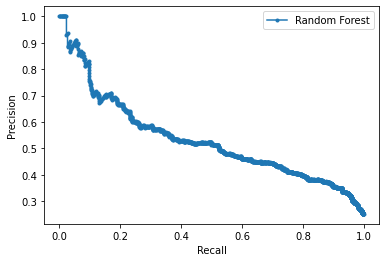

Random Forest: f1=0.441 auc=0.533

 When selecting samples with >= 60% probability, we select 96 from 380 with a precision of 0.7083333333333334



Estimator for Segment: Large with target function as: Large, +10% Growth 
 

[[1435  169]
 [ 398  275]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.84      1604
           1       0.62      0.41      0.49       673

    accuracy                           0.75      2277
   macro avg       0.70      0.65      0.66      2277
weighted avg       0.73      0.75      0.73      2277

The balanced accuracy of the model is: 0.65


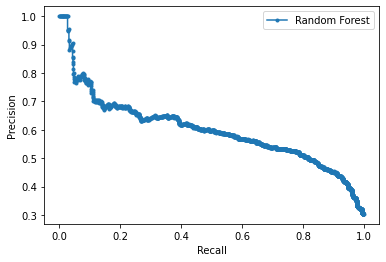

Random Forest: f1=0.492 auc=0.600

 When selecting samples with >= 60% probability, we select 169 from 444 with a precision of 0.6863905325443787



Estimator for Segment: Mid-Market with target function as: Mid-Market, +25% Growth 
 

[[1265  449]
 [ 200  363]]
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      1714
           1       0.45      0.64      0.53       563

    accuracy                           0.71      2277
   macro avg       0.66      0.69      0.66      2277
weighted avg       0.76      0.71      0.73      2277

The balanced accuracy of the model is: 0.69


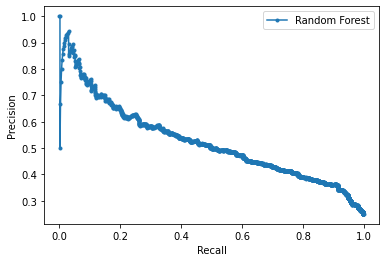

Random Forest: f1=0.528 auc=0.524

 When selecting samples with >= 60% probability, we select 113 from 812 with a precision of 0.6991150442477876



Estimator for Segment: Mid-Market with target function as: Mid-Market, +10% Growth 
 

[[1220  384]
 [ 205  468]]
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1604
           1       0.55      0.70      0.61       673

    accuracy                           0.74      2277
   macro avg       0.70      0.73      0.71      2277
weighted avg       0.77      0.74      0.75      2277

The balanced accuracy of the model is: 0.73


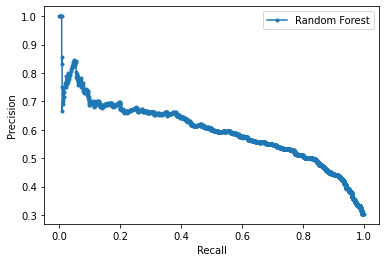

Random Forest: f1=0.614 auc=0.596

 When selecting samples with >= 60% probability, we select 102 from 852 with a precision of 0.696078431372549



Estimator for Segment: SMB with target function as: SMB, +25% Growth 
 

[[995 719]
 [ 84 479]]
              precision    recall  f1-score   support

           0       0.92      0.58      0.71      1714
           1       0.40      0.85      0.54       563

    accuracy                           0.65      2277
   macro avg       0.66      0.72      0.63      2277
weighted avg       0.79      0.65      0.67      2277

The balanced accuracy of the model is: 0.72


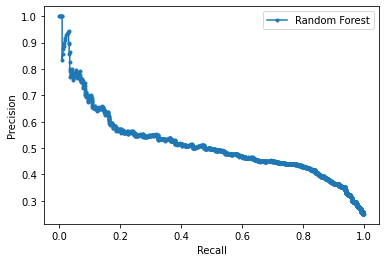

Random Forest: f1=0.544 auc=0.513

 When selecting samples with >= 60% probability, we select 390 from 1198 with a precision of 0.5282051282051282



Estimator for Segment: SMB with target function as: SMB, +10% Growth 
 

[[1000  604]
 [  85  588]]
              precision    recall  f1-score   support

           0       0.92      0.62      0.74      1604
           1       0.49      0.87      0.63       673

    accuracy                           0.70      2277
   macro avg       0.71      0.75      0.69      2277
weighted avg       0.80      0.70      0.71      2277

The balanced accuracy of the model is: 0.75


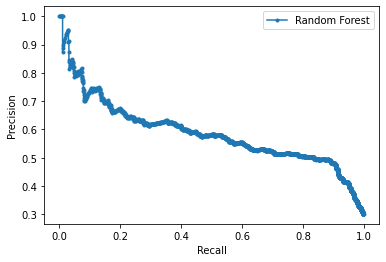

Random Forest: f1=0.631 auc=0.588

 When selecting samples with >= 60% probability, we select 579 from 1192 with a precision of 0.5820379965457686




In [48]:
input_fields_list = input_fields(categorical_variables)

# for each scenario run the model
for est in estimators:
    
    print ('\nEstimator for Segment: {} with target function as: {} \n \n'.format( est['segment'],  est['name']))
    temp = train_df[train_df['ULTIMATE_PARENT_ACCOUNT_SEGMENT'] == est['segment']]
    
    x = temp[input_fields_list]
    y = temp[est['target_field']]
    
    x, y = resample_dataset(x, y, random_state = RANDOM_STATE)
    
    # check params
    try:
        param = est['param']
    except KeyError:
        # Key is not present
        # estimate parameters

        param = None
        est['estimator'] = fit_rfc_estimator(x, y, param, random_state = RANDOM_STATE)
        param = estimate_parameters(est['estimator'], x, y)
        print(param)       
        est['param'] = param

    est['estimator'] = fit_rfc_estimator(x, y, param)
        
    #evaluate results
    test_y = test_df[est['target_field']].values
    test_x = test_df[input_fields_list].values.reshape(-1,len(input_fields_list))
    test_pred_y  = est['estimator'].predict(test_x)
    test_pred_y_prod  = est['estimator'].predict_proba(test_x)
    
    
    # calculate evaluation metrics
    evaluate_results(test_y, test_pred_y, test_pred_y_prod)
    
    # calculate cross validation mean and average   
    scoring = {'precision': 'precision',
               'balanced_accuracy': 'balanced_accuracy',
               'rec_binary': make_scorer(recall_score, pos_label=1, average='binary'),
               'pre_binary': make_scorer(precision_score, pos_label=1, average='binary')}
    

    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
    
    #scoring = ['precision', 'recall_binary','balanced_accuracy']
    est['cv_accuracies'] = pd.DataFrame(cross_validate(estimator=est['estimator'], X=x, y=y.ravel(), cv=NUM_CROSS_FOLD_RUNS, scoring=scoring))
       
    total, selected, est['precision_over_60_perc_prob'] = precision_over_probability(test_y.ravel(), test_pred_y_prod, 0.60)
    
    print('\n When selecting samples with >= 60% probability, we select {} from {} with a precision of {}'.format(selected, total,  est['precision_over_60_perc_prob']))
    
    print ('\n') 
    
    
    #mse, bias, var = bias_variance_decomp(est['estimator'], x, y.ravel(), test_x, test_y, loss='mse', num_rounds=200, random_seed=1)
    
    # summarize results
    #print('MSE: %.3f' % mse)
    #print('Bias: %.3f' % bias)
    #print('Variance: %.3f' % var)
    
record_accuracies_of_estimators(estimators)
 

## Run predictions

In [49]:
# download the data for prediction
if DOWNLOAD_DATA or 'to_predict_df' not in locals():
    to_predict_large_mm_df = pd.read_csv('https://app.periscopedata.com/api/gitlab/chart/csv/40cc59bc-90d8-56b1-d95f-62a56cec51de')
    #to_predict_smb_df = pd.read_csv('')
    
    #to_predict_df = pd.concat([to_predict_large_mm_df,to_predict_smb_df])
    to_predict_df = to_predict_large_mm_df

predict_df = to_predict_df.copy()
predict_df = data_preparation(predict_df)
predict_df_categorical_variables, predict_df = process_categorical_variables(predict_df)

In [50]:
#specially for categorical variables, sometimes we do no have in the to-predict dataset some of the trained variables
def standardise_to_predict_dataset(df, input_variables):
    # remove variables in the predict dataset not in the model
    adj_input_variables = [x for x in list(df.columns) if x in input_variables]

    # create dummy values for missing variables in dataset
    missing_variables = [x for x in input_variables if x not in list(df.columns)]
    for var in missing_variables:
        #print(var)
        adj_input_variables.extend([var])
        df[var] = 0
        
    return df, adj_input_variables

In [51]:
# adjust input fields to categorical variables
to_predict_input_fields = input_fields(categorical_variables)
# adjust to predict dataset to account for missing categorical variables
predict_df, to_predict_input_fields = standardise_to_predict_dataset(predict_df, to_predict_input_fields)

for est in estimators:
    
    index = (predict_df['ULTIMATE_PARENT_ACCOUNT_SEGMENT'] == est['segment'])
    
    print ('\nEstimator for Segment: {} with target function as: {} \n \n'.format( est['segment'],  est['name']))
    
    # store positive probability
    temp_prob = est['estimator'].predict_proba(predict_df[index][to_predict_input_fields].values)[:,1]
    temp_pred = est['estimator'].predict(predict_df[index][to_predict_input_fields].values)
    predict_df.loc[index, est['prob_field_name']] = temp_prob
    predict_df.loc[index, est['pred_field_name']] = temp_pred
   
    print(len(predict_df.loc[index, est['pred_field_name']]), ' ', len(pd.Series(temp_pred)))
    
    print ('\n')                                                                                                             

                                


Estimator for Segment: Large with target function as: Large, +25% Growth 
 

1583   1583



Estimator for Segment: Large with target function as: Large, +10% Growth 
 

1583   1583



Estimator for Segment: Mid-Market with target function as: Mid-Market, +25% Growth 
 

2459   2459



Estimator for Segment: Mid-Market with target function as: Mid-Market, +10% Growth 
 

2459   2459



Estimator for Segment: SMB with target function as: SMB, +25% Growth 
 

9131   9131



Estimator for Segment: SMB with target function as: SMB, +10% Growth 
 

9131   9131




In [52]:
output_cols = ['ULTIMATE_PARENT_ACCOUNT_ID',
                'ULTIMATE_PARENT_ACCOUNT_SEGMENT',
                 'CURRENT_MONTH',
                'over_25_perc_growth_prob',
                'over_10_perc_growth_prob',
                 'will_grow_over_10_perc_flag',
                 'will_grow_over_25_perc_flag',
                 'CURRENT_ARR',
                 'MINUS_1P_ARR',
                 'MINUS_2P_ARR',
                 'CURRENT_CREATED_OPTIES',
                 'MINUS_1_CREATED_OPTIES',
                 'MINUS_2_CREATED_OPTIES',
                 'CURRENT_WON_OPTIES',
                 'MINUS_1_WON_OPTIES',
                 'MINUS_2_WON_OPTIES',
                 'CURRENT_LOST_OPTIES',
                 'MINUS_1_LOST_OPTIES',
                 'MINUS_2_LOST_OPTIES',
                 'CURRENT_CREATED_CONTACTS',
                 'MINUS_1_CREATED_CONTACTS',
                 'MINUS_2_CREATED_CONTACTS',
                 'MINUS_3_CREATED_CONTACTS',
                 'CURRENT_CREATED_SUPPORT_TICKETS',
                 'MINUS_1_CREATED_SUPPORT_TICKETS',
                 'MINUS_2_CREATED_SUPPORT_TICKETS',
                 'MINUS_3_CREATED_SUPPORT_TICKETS',
                 'MINUS_4_CREATED_SUPPORT_TICKETS',
                 'CURRENT_SFDC_TASKS',
                 'MINUS_1_SFDC_TASKS',
                 'MINUS_2_SFDC_TASKS',
                 'MINUS_3_SFDC_TASKS',
                 'CURRENT_BIZ_TOUCHPOINTS',
                 'MINUS_1_BIZ_TOUCHPOINTS',
                 'MINUS_2_BIZ_TOUCHPOINTS',
                 'MINUS_3_BIZ_TOUCHPOINTS',
                 'CURRENT_PING_COUNT',
                 'MINUS_1_PING_COUNT',
                 'MINUS_2_PING_COUNT',
                 'MINUS_3_PING_COUNT',
                 'MINUS_4_PING_COUNT',
                 'CURRENT_AVG_INSTANCE_USER_COUNT',
                 'MINUS_1_AVG_INSTANCE_USER_COUNT',
                 'MINUS_2_AVG_INSTANCE_USER_COUNT',
                 'MINUS_3_AVG_INSTANCE_USER_COUNT',
                 'MINUS_4_AVG_INSTANCE_USER_COUNT',
                 'CURRENT_SEAT_CHANGE_ARR',
                 'MINUS_1_SEAT_CHANGE_ARR',
                 'MINUS_2_SEAT_CHANGE_ARR',
                 'CURRENT_PRICE_CHANGE_ARR',
                 'MINUS_1_PRICE_CHANGE_ARR',
                 'MINUS_2_PRICE_CHANGE_ARR',
                 'CURRENT_TIER_CHANGE_ARR',
                 'MINUS_1_TIER_CHANGE_ARR',
                 'MINUS_2_TIER_CHANGE_ARR',
                 'CURRENT_NUMBER_SEATS',
                 'MINUS_1_NUMBER_SEATS',
                 'MINUS_2_NUMBER_SEATS',
                 'CURRENT_PRODUCT',
                 'MINUS_1_PRODUCT',
                 'MINUS_2_PRODUCT',
                 'DELIVERY',
                 'UPA_INDUSTRY',
                 'CURRENT_GROWTH',
                 'MINUS_1_GROWTH']

In [53]:
predict_df[output_cols].to_csv('predicted_upa_all.csv')